In [1]:
!nvidia-smi

Tue Mar 25 19:30:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             43W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
!git clone https://github.com/ostris/ai-toolkit
!mkdir -p /content/dataset

Cloning into 'ai-toolkit'...
remote: Enumerating objects: 5547, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 5547 (delta 141), reused 128 (delta 114), pack-reused 5370 (from 2)
Receiving objects: 100% (5547/5547), 30.66 MiB | 16.56 MiB/s, done.
Resolving deltas: 100% (3923/3923), done.


In [3]:
!cd ai-toolkit && git submodule update --init --recursive && pip install -q -r requirements.txt

Submodule 'repositories/batch_annotator' (https://github.com/ostris/batch-annotator) registered for path 'repositories/batch_annotator'
Submodule 'repositories/ipadapter' (https://github.com/tencent-ailab/IP-Adapter.git) registered for path 'repositories/ipadapter'
Submodule 'repositories/leco' (https://github.com/p1atdev/LECO) registered for path 'repositories/leco'
Submodule 'repositories/sd-scripts' (https://github.com/kohya-ss/sd-scripts.git) registered for path 'repositories/sd-scripts'
Cloning into '/content/ai-toolkit/repositories/batch_annotator'...
Cloning into '/content/ai-toolkit/repositories/ipadapter'...
Cloning into '/content/ai-toolkit/repositories/leco'...
Cloning into '/content/ai-toolkit/repositories/sd-scripts'...
Submodule path 'repositories/batch_annotator': checked out '420e142f6ad3cc14b3ea0500affc2c6c7e7544bf'
Submodule 'repositories/controlnet' (https://github.com/lllyasviel/ControlNet-v1-1-nightly.git) registered for path 'repositories/batch_annotator/repositor

In [4]:
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.


In [5]:
from google.colab import userdata
from huggingface_hub import login

hf_token = userdata.get('hf_token')
login(token=hf_token)

In [1]:
import os
import sys
sys.path.append('/content/ai-toolkit')
from toolkit.job import run_job
from collections import OrderedDict
from PIL import Image
import os
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"
from datasets import load_dataset

In [2]:
def create_updated_dataset():
    # Load your updated dataset that now includes 'id' and 'caption'
    dataset = load_dataset("dolphinium/wikiart-impressionism-curated")

    # Ensure the output directory exists
    os.makedirs("/content/dataset", exist_ok=True)

    # Process each image in the dataset
    for item in dataset['train']:
        # Retrieve the image, id, and caption from the new columns
        image = item['image']
        img_id = item['id']  # using your new 'id' column for filenames
        caption_text = item['caption']  # use the provided caption

        # Save the image with a filename based on the id
        image_filename = f"image_{img_id:04d}.jpg"
        image.save(os.path.join("/content/dataset", image_filename))

        # Save the caption to a text file with the same basename
        caption_filename = f"image_{img_id:04d}.txt"
        with open(os.path.join("/content/dataset", caption_filename), 'w') as f:
            f.write(caption_text)

create_updated_dataset()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
from collections import OrderedDict

job_to_run = OrderedDict([
    ('job', 'extension'),
    ('config', OrderedDict([
        # this name will be the folder and filename name
        ('name', 'flux_1_dev_wikiart_impressionism_v2'),
        ('process', [
            OrderedDict([
                ('type', 'sd_trainer'),
                # root folder to save training sessions/samples/weights
                ('training_folder', '/content/output'),
                # uncomment to see performance stats in the terminal every N steps
                #('performance_log_every', 1000),
                ('device', 'cuda:0'),
                # if a trigger word is specified, it will be added to captions of training data if it does not already exist
                # alternatively, in your captions you can add [trigger] and it will be replaced with the trigger word
                # ('trigger_word', 'impressionism'),
                ('network', OrderedDict([
                    ('type', 'lora'),
                    ('linear', 16),
                    ('linear_alpha', 16)
                ])),
                ('save', OrderedDict([
                    ('dtype', 'float16'),  # precision to save
                    ('save_every', 250),  # save every this many steps
                    ('max_step_saves_to_keep', 10)  # how many intermittent saves to keep
                ])),
                ('datasets', [
                    # datasets are a folder of images. captions need to be txt files with the same name as the image
                    # for instance image2.jpg and image2.txt. Only jpg, jpeg, and png are supported currently
                    # images will automatically be resized and bucketed into the resolution specified
                    OrderedDict([
                        ('folder_path', '/content/dataset'),
                        ('caption_ext', 'txt'),
                        ('caption_dropout_rate', 0.05),  # will drop out the caption 5% of time
                        ('shuffle_tokens', True),  # shuffle caption order, split by commas
                        ('cache_latents_to_disk', True),  # leave this true unless you know what you're doing
                        ('resolution', [512, 768, 1024])  # flux enjoys multiple resolutions
                    ])
                ]),
                ('train', OrderedDict([
                    ('batch_size', 1),
                    ('steps', 1000),  # total number of steps to train 500 - 4000 is a good range
                    ('gradient_accumulation_steps', 1),
                    ('train_unet', True),
                    ('train_text_encoder', False),  # probably won't work with flux
                    ('content_or_style', 'balanced'),  # content, style, balanced
                    ('gradient_checkpointing', True),  # need the on unless you have a ton of vram
                    ('noise_scheduler', 'flowmatch'),  # for training only
                    ('optimizer', 'adamw8bit'),
                    ('lr', 1e-4),

                    # uncomment this to skip the pre training sample
                    # ('skip_first_sample', True),

                    # uncomment to completely disable sampling
                    # ('disable_sampling', True),

                    # uncomment to use new vell curved weighting. Experimental but may produce better results
                    # ('linear_timesteps', True),

                    # ema will smooth out learning, but could slow it down. Recommended to leave on.
                    ('ema_config', OrderedDict([
                        ('use_ema', False),
                        ('ema_decay', 0.99)
                    ])),

                    # will probably need this if gpu supports it for flux, other dtypes may not work correctly
                    ('dtype', 'bf16')
                ])),
                ('model', OrderedDict([
                    # huggingface model name or path
                    ('name_or_path', 'black-forest-labs/FLUX.1-dev'),
                    ('is_flux', True),
                    ('quantize', True),  # run 8bit mixed precision
                    #('low_vram', True),  # uncomment this if the GPU is connected to your monitors. It will use less vram to quantize, but is slower.
                ])),
                ('sample', OrderedDict([
                    ('sampler', 'flowmatch'),  # must match train.noise_scheduler
                    ('sample_every', 100),  # sample every this many steps
                    ('width', 1024),
                    ('height', 1024),
                    ('prompts', [
                        # you can add [trigger] to the prompts here and it will be replaced with the trigger word
                        #'[trigger] holding a sign that says \'I LOVE PROMPTS!\'',
                        'An impressionist painting portrays a vast landscape with gently rolling hills under a radiant sky. Clusters of autumn trees dot the scene, rendered with loose, expressive brushstrokes and a palette of warm oranges, deep greens, and soft blues, creating a sense of tranquil, natural beauty.',
                        'An impressionist portrait captures the delicate expression of a woman bathed in soft, natural light. The artist employs bold, yet subtle brushstrokes to emphasize the subject’s serene features and gentle contours, all set against a background of softly blended pastel tones that evoke introspection and grace.',
                        'An impressionist painting depicts a lively urban scene where a row of quaint cafe terraces lines a bustling street. The dynamic brushstrokes and vibrant splashes of color capture the interplay of sunlight and shadows on the cityscape, hinting at the rhythm of urban life and the charm of everyday moments.',
                        'An impressionist still life showcases a harmonious arrangement of fresh flowers and classic tableware. The interplay of light and shadow is rendered through loose, fluid brushstrokes and a carefully chosen palette, highlighting delicate textures and vibrant hues that evoke the transient beauty of everyday objects.'
                    ]),
                    ('neg', ''),  # not used on flux
                    ('seed', 1337),
                    ('walk_seed', True),
                    ('guidance_scale', 4),
                    ('sample_steps', 20)
                ]))
            ])
        ])
    ])),
    # you can add any additional meta info here. [name] is replaced with config name at top
    ('meta', OrderedDict([
        ('name', '[name]'),
        ('version', '1.0')
    ]))
])


In [4]:
run_job(job_to_run)

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/local/lib/python3.11/dist-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated

{
    "type": "sd_trainer",
    "training_folder": "/content/output",
    "device": "cuda:0",
    "network": {
        "type": "lora",
        "linear": 16,
        "linear_alpha": 16
    },
    "save": {
        "dtype": "float16",
        "save_every": 250,
        "max_step_saves_to_keep": 10
    },
    "datasets": [
        {
            "folder_path": "/content/dataset",
            "caption_ext": "txt",
            "caption_dropout_rate": 0.05,
            "shuffle_tokens": true,
            "cache_latents_to_disk": true,
            "resolution": [
                512,
                768,
                1024
            ]
        }
    ],
    "train": {
        "batch_size": 1,
        "steps": 1000,
        "gradient_accumulation_steps": 1,
        "train_unet": true,
        "train_text_encoder": false,
        "content_or_style": "balanced",
        "gradient_checkpointing": true,
        "noise_scheduler": "flowmatch",
        "optimizer": "adamw8bit",
        "lr": 0.0001

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Quantizing transformer
Loading VAE
Loading T5


You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Quantizing T5
Loading CLIP
Making pipe
Preparing Model
create LoRA network. base dim (rank): 16, alpha: 16
neuron dropout: p=None, rank dropout: p=None, module dropout: p=None
create LoRA for Text Encoder: 0 modules.
create LoRA for U-Net: 494 modules.
enable LoRA for U-Net
Dataset: /content/dataset
  -  Preprocessing image dimensions


100%|██████████| 1000/1000 [00:00<00:00, 57713.16it/s]

  -  Found 1000 images
Bucket sizes for /content/dataset:
576x448: 252 files
512x448: 129 files
576x384: 135 files
448x576: 212 files
384x576: 67 files
448x512: 91 files
640x384: 54 files
512x512: 27 files
384x640: 20 files
640x320: 12 files
320x704: 1 files
11 buckets made
Caching latents for /content/dataset
 - Saving latents to disk



Caching latents to disk: 100%|██████████| 1000/1000 [00:00<00:00, 46295.77it/s]


Dataset: /content/dataset
  -  Preprocessing image dimensions


100%|██████████| 1000/1000 [00:00<00:00, 60746.52it/s]

  -  Found 1000 images
Bucket sizes for /content/dataset:
832x640: 139 files
768x640: 207 files
832x576: 108 files
640x768: 139 files
896x576: 50 files
640x832: 129 files
576x832: 57 files
576x896: 29 files
960x576: 43 files
768x704: 25 files
704x768: 27 files
768x768: 16 files
512x1024: 4 files
576x960: 11 files
960x512: 16 files
15 buckets made
Caching latents for /content/dataset
 - Saving latents to disk



Caching latents to disk: 100%|██████████| 1000/1000 [00:00<00:00, 42885.23it/s]


Dataset: /content/dataset
  -  Preprocessing image dimensions


100%|██████████| 1000/1000 [00:00<00:00, 64082.14it/s]

  -  Found 1000 images
Bucket sizes for /content/dataset:
1152x896: 97 files
1088x896: 196 files
1152x832: 95 files
896x1152: 104 files
1216x832: 88 files
832x1152: 60 files
896x1088: 127 files
832x1216: 44 files
1088x960: 21 files
1280x768: 49 files
1024x960: 16 files
960x1088: 23 files
768x1280: 15 files
1344x768: 20 files
1024x1024: 13 files
704x1408: 3 files
960x1024: 12 files
768x1344: 8 files
1344x704: 9 files
19 buckets made
Caching latents for /content/dataset
 - Saving latents to disk



Caching latents to disk: 100%|██████████| 1000/1000 [00:00<00:00, 43366.77it/s]


Generating baseline samples before training


flux_1_dev_wikiart_impressionism_v2:  25%|██▍       | 249/1000 [09:37<33:44,  2.70s/it, lr: 1.0e-04 loss: 4.600e-01]

Saving at step 250
Saved to /content/output/flux_1_dev_wikiart_impressionism_v2/optimizer.pt


Generating Images: 100%|██████████| 4/4 [01:13<00:00, 18.43s/it]
                                                                

Saving at step 500
Saved to /content/output/flux_1_dev_wikiart_impressionism_v2/optimizer.pt


flux_1_dev_wikiart_impressionism_v2:  75%|███████▍  | 749/1000 [28:46<09:54,  2.37s/it, lr: 1.0e-04 loss: 3.927e-01]

Saving at step 750
Saved to /content/output/flux_1_dev_wikiart_impressionism_v2/optimizer.pt


flux_1_dev_wikiart_impressionism_v2: 100%|█████████▉| 999/1000 [38:03<00:02,  2.29s/it, lr: 1.0e-04 loss: 3.373e-01]



Saved to /content/output/flux_1_dev_wikiart_impressionism_v2/optimizer.pt


In [5]:
from huggingface_hub import HfApi, create_repo, upload_folder
import os
from getpass import getpass
import json

def push_to_huggingface(
    local_path="/content/output/flux_1_dev_wikiart_impressionism_v2",
    repo_name="FLUX.1-dev-wikiart-impressionism",
    organization=None  # Set this if you want to push to an organization
):
    """
    Push the trained model to Hugging Face Hub

    Args:
        local_path: Path to the trained model folder
        repo_name: Name for the Hugging Face repository
        organization: Optional organization name to push to
    """

    api = HfApi()

    try:
        # api.set_access_token(hf_token)

        # Create model card content
        model_card = """---
tags:
- flux
- stable-diffusion
- text-to-image
- lora
- flux dev
- diffusers
- impressionism
library_name: diffusers
pipeline_tag: text-to-image
base_model: black-forest-labs/FLUX.1-dev
---

# FLUX.1-dev Impressionism fine-tuning with LoRA

This is a LoRA fine-tuning of the FLUX.1 model trained on a curated dataset of impressionist paintings from WikiArt.

## Dataset
The model was trained on the [WikiArt Impressionism Curated Dataset](https://huggingface.co/datasets/dolphinium/wikiart-impressionism-curated), which contains 1,000 high-quality Impressionist paintings with the following distribution:

- Landscapes: 300 images (30%)
- Portraits: 300 images (30%)
- Urban Scenes: 200 images (20%)
- Still Life: 200 images (20%)

## Model Details
- Base Model: [FLUX.1](https://huggingface.co/black-forest-labs/FLUX.1-dev)
- LoRA Rank: 16
- Training Steps: 2000
- Resolution: 512-1024px

## Usage

```python
from diffusers import StableDiffusionPipeline
import torch

model_id = "black-forest-labs/FLUX.1-dev"
lora_model_path = "{repo_path}"

pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16
).to("cuda")

# Load LoRA weights
pipe.unet.load_attn_procs(lora_model_path)

# Generate image
prompt = "an impressionist style landscape with rolling hills and autumn trees"
image = pipe(prompt).images[0]
image.save("impressionist_landscape.png")
```


## License
This model inherits the license of the base FLUX.1 model and the WikiArt dataset.
"""

        # Determine the full repository name
        if organization:
            repo_id = f"{organization}/{repo_name}"
        else:
            repo_id = f"{api.whoami()['name']}/{repo_name}"

        # Create the repository
        print(f"Creating repository: {repo_id}")
        create_repo(
            repo_id,
            private=False,
            exist_ok=True
        )

        # Create README.md in the local directory
        readme_path = os.path.join(local_path, "README.md")
        with open(readme_path, "w") as f:
            f.write(model_card.format(repo_path=repo_id))

        # Push the folder to Hugging Face
        print(f"Uploading files to {repo_id}...")
        api.upload_folder(
            folder_path=local_path,
            repo_id=repo_id,
            repo_type="model"
        )

        print(f"\nSuccess! Model pushed to: https://huggingface.co/{repo_id}")

    except Exception as e:
        print(f"An error occurred: {str(e)}")

# Create a metadata file
def create_metadata(local_path, training_config):
    """Create a metadata.json file with training details"""
    metadata = {
        "base_model": "black-forest-labs/FLUX.1-dev",
        "dataset": "dolphinium/wikiart-impressionism-curated",
        "training_config": training_config,
    }

    with open(os.path.join(local_path, "metadata.json"), "w") as f:
        json.dump(metadata, f, indent=2)

create_metadata("/content/output/flux_1_dev_wikiart_impressionism_v2", training_config=job_to_run)

    # Then push to Hugging Face
push_to_huggingface(
    local_path="/content/output/flux_1_dev_wikiart_impressionism_v2",
    repo_name="FLUX.1-dev-wikiart-impressionism"  # Change this to your preferred repository name
    )

Creating repository: dolphinium/FLUX.1-dev-wikiart-impressionism
Uploading files to dolphinium/FLUX.1-dev-wikiart-impressionism...


  0%|          | 0/49 [00:00<?, ?it/s]

(…)dev_wikiart_impressionism_v2.safetensors:   0%|          | 0.00/172M [00:00<?, ?B/s]

(…)t_impressionism_v2_000000250.safetensors:   0%|          | 0.00/172M [00:00<?, ?B/s]

(…)t_impressionism_v2_000000500.safetensors:   0%|          | 0.00/172M [00:00<?, ?B/s]

(…)t_impressionism_v2_000000750.safetensors:   0%|          | 0.00/172M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/176M [00:00<?, ?B/s]

samples/1742933301431__000000000_0.jpg:   0%|          | 0.00/107k [00:00<?, ?B/s]

samples/1742933319860__000000000_1.jpg:   0%|          | 0.00/104k [00:00<?, ?B/s]

samples/1742933338295__000000000_2.jpg:   0%|          | 0.00/200k [00:00<?, ?B/s]

samples/1742933356725__000000000_3.jpg:   0%|          | 0.00/147k [00:00<?, ?B/s]

samples/1742933620018__000000100_0.jpg:   0%|          | 0.00/106k [00:00<?, ?B/s]

samples/1742933638449__000000100_1.jpg:   0%|          | 0.00/104k [00:00<?, ?B/s]

samples/1742933656865__000000100_2.jpg:   0%|          | 0.00/204k [00:00<?, ?B/s]

samples/1742933675288__000000100_3.jpg:   0%|          | 0.00/151k [00:00<?, ?B/s]

samples/1742933915263__000000200_0.jpg:   0%|          | 0.00/106k [00:00<?, ?B/s]

samples/1742933933683__000000200_1.jpg:   0%|          | 0.00/106k [00:00<?, ?B/s]

samples/1742933952102__000000200_2.jpg:   0%|          | 0.00/201k [00:00<?, ?B/s]

samples/1742933970519__000000200_3.jpg:   0%|          | 0.00/164k [00:00<?, ?B/s]

samples/1742934222314__000000300_0.jpg:   0%|          | 0.00/113k [00:00<?, ?B/s]

samples/1742934240741__000000300_1.jpg:   0%|          | 0.00/113k [00:00<?, ?B/s]

samples/1742934259165__000000300_2.jpg:   0%|          | 0.00/206k [00:00<?, ?B/s]

samples/1742934277584__000000300_3.jpg:   0%|          | 0.00/170k [00:00<?, ?B/s]

samples/1742934525719__000000400_0.jpg:   0%|          | 0.00/119k [00:00<?, ?B/s]

samples/1742934544139__000000400_1.jpg:   0%|          | 0.00/118k [00:00<?, ?B/s]

samples/1742934562553__000000400_2.jpg:   0%|          | 0.00/217k [00:00<?, ?B/s]

samples/1742934580972__000000400_3.jpg:   0%|          | 0.00/182k [00:00<?, ?B/s]

samples/1742934833996__000000500_0.jpg:   0%|          | 0.00/120k [00:00<?, ?B/s]

samples/1742934852418__000000500_1.jpg:   0%|          | 0.00/120k [00:00<?, ?B/s]

samples/1742934870847__000000500_2.jpg:   0%|          | 0.00/215k [00:00<?, ?B/s]

samples/1742934889270__000000500_3.jpg:   0%|          | 0.00/182k [00:00<?, ?B/s]

samples/1742935151482__000000600_0.jpg:   0%|          | 0.00/116k [00:00<?, ?B/s]

samples/1742935169913__000000600_1.jpg:   0%|          | 0.00/115k [00:00<?, ?B/s]

samples/1742935188329__000000600_2.jpg:   0%|          | 0.00/205k [00:00<?, ?B/s]

samples/1742935206744__000000600_3.jpg:   0%|          | 0.00/179k [00:00<?, ?B/s]

samples/1742935463744__000000700_0.jpg:   0%|          | 0.00/119k [00:00<?, ?B/s]

samples/1742935482167__000000700_1.jpg:   0%|          | 0.00/121k [00:00<?, ?B/s]

samples/1742935500576__000000700_2.jpg:   0%|          | 0.00/215k [00:00<?, ?B/s]

samples/1742935518995__000000700_3.jpg:   0%|          | 0.00/184k [00:00<?, ?B/s]

samples/1742935766113__000000800_0.jpg:   0%|          | 0.00/123k [00:00<?, ?B/s]

samples/1742935784529__000000800_1.jpg:   0%|          | 0.00/124k [00:00<?, ?B/s]

samples/1742935802947__000000800_2.jpg:   0%|          | 0.00/216k [00:00<?, ?B/s]

samples/1742935821367__000000800_3.jpg:   0%|          | 0.00/186k [00:00<?, ?B/s]

samples/1742936073376__000000900_0.jpg:   0%|          | 0.00/119k [00:00<?, ?B/s]

samples/1742936091818__000000900_1.jpg:   0%|          | 0.00/121k [00:00<?, ?B/s]

samples/1742936110258__000000900_2.jpg:   0%|          | 0.00/213k [00:00<?, ?B/s]

samples/1742936128699__000000900_3.jpg:   0%|          | 0.00/183k [00:00<?, ?B/s]

samples/1742936368658__000001000_0.jpg:   0%|          | 0.00/123k [00:00<?, ?B/s]

samples/1742936387076__000001000_1.jpg:   0%|          | 0.00/127k [00:00<?, ?B/s]

samples/1742936405497__000001000_2.jpg:   0%|          | 0.00/217k [00:00<?, ?B/s]

samples/1742936423931__000001000_3.jpg:   0%|          | 0.00/187k [00:00<?, ?B/s]


Success! Model pushed to: https://huggingface.co/dolphinium/FLUX.1-dev-wikiart-impressionism


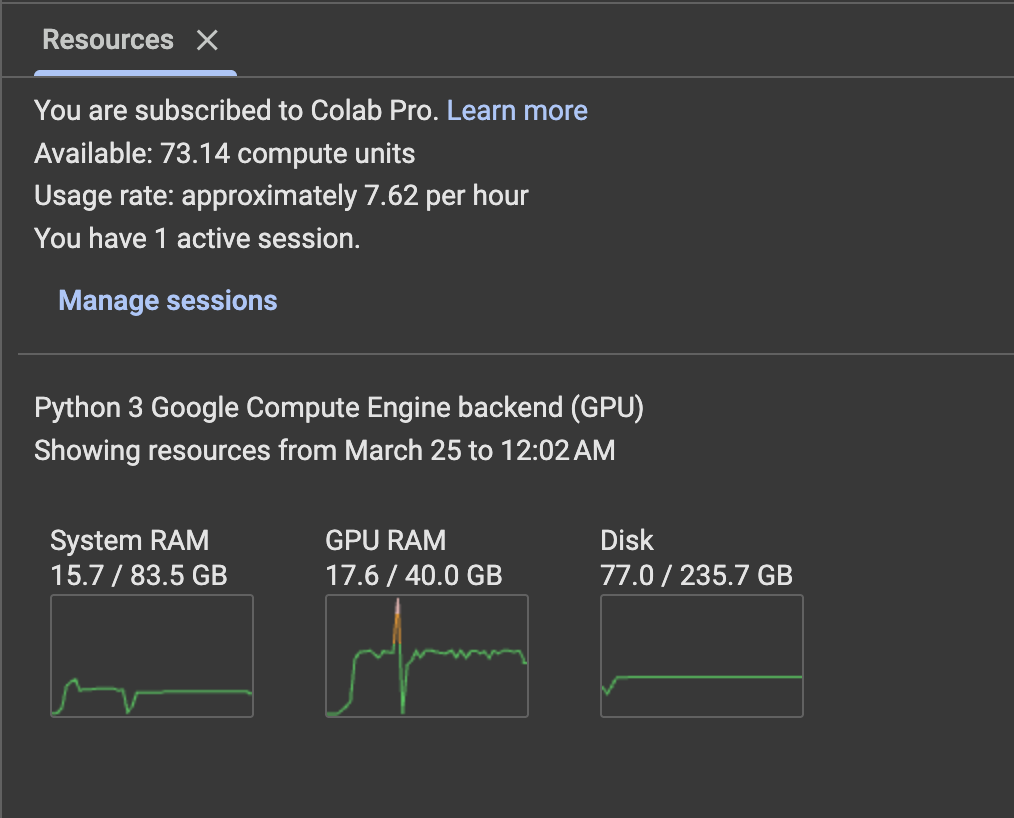